### Group 28 members:
- Jingze Tian (CCID)
- Letian Ren (CCID)
- Essam Gouda (egouda)

# Task 1: Regression
- Linear Regression for no_of_Mosquito = function(weather_features)
- Linear Regression for no_of_Mosquito_female = function(weather_features)
- Linear Regression for no_of_Mosquito_male = function(weather_features)
- Polynomial Regression for no_of_Mosquito_female = function(weather_features)
- Polynomial Regression for no_of_Mosquito_male = function(weather_features)

#### Variations for each model:
- Different cost functions were tested
- Model without normalization and standardization, model with normalization only, model with standardization only, model with both normalization and standardization.
- Feature selection
- model statistics compared at the end

## Imports

In [312]:
import pandas as pd
import numpy as np
import time


import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white bg for sns plots
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy.stats import ks_2samp

import warnings; warnings.simplefilter('ignore')

## Read csv files (datasets)

In [313]:
weather_data = pd.read_csv('./data/weather_data.csv')
mos_data = pd.read_csv('./data/mosquito_data_new.csv')

In [314]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,09/15/2015 12:00:00 AM,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,05/12/1998 12:00:00 AM,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,08/28/2001 12:00:00 AM,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,08/17/2004 12:00:00 AM,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,05/15/2018 12:00:00 AM,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


In [315]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2018-12-18 16:00:00 MST,1545174000,91.73,99.7,SW,23.0,5.0,NaN,64.0,-7.3,-1.3,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-18 15:00:00 MST,1545170400,91.67,99.7,S,18.0,5.0,NaN,65.0,-6.3,-0.5,-2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2018-12-18 14:00:00 MST,1545166800,91.67,99.6,S,17.0,5.0,NaN,51.0,-6.5,2.7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,2018-12-18 13:00:00 MST,1545163200,91.66,99.6,SE,13.0,2.0,NaN,50.0,-6.4,2.9,NaN,NaN,NaN,3.9,NaN,NaN,NaN,NaN
4,2018-12-18 12:00:00 MST,1545159600,91.75,99.7,NaN,NaN,0.0,NaN,59.0,-6.6,0.5,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN


### Standardize mosquito trap date format

In [316]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list

mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,2015-09-15,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,1998-05-12,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,2001-08-28,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,2004-08-17,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,2018-05-15,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


### Align date ranges in both datasets
Both datasets have different date ranges

In [317]:
mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] > start_remove) & (mos_data["Trap Date"] < end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))


mos_range = (mos_data['Trap Date'] > mos_date_start) & (mos_data['Trap Date'] < mos_date_end)
mos_data = mos_data.loc[mos_range]
print(mos_data) #
mos_data = mos_data.sort_values(by='Trap Date')
mos_data #final mos_data

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25
       Trap Date         Genus Specific Epithet  Gender   IDd  Count  \
4     2018-05-15      Culiseta        impatiens  Female   NaN      2   
6     2018-08-07         Aedes           vexans  Female   NaN     11   
14    2017-06-13         Aedes         dorsalis  Female   NaN      1   
17    2017-08-29         Aedes           vexans  Female   NaN     21   
18    2017-06-20      Culiseta         inornata  Female   NaN      5   
20    2017-08-15         Culex        territans  Female   NaN      1   
30    2018-07-03         Aedes           vexans  Female   NaN     42   
36    2017-06-27          Male             UnID    Male  UnID      8   
38    2017-09-05         Aedes         dorsalis  Female   NaN      1   
40    2018-09-18          Male             UnID    Male  UnID      6   
46    2017-09-26          Male             UnID    Male  UnID      6   
48    2017-05-23          Male             UnID    Male  UnID     15   
6

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
19195,2017-05-16,Ochlerotatus,Black legs,Female,UnID,13,Residential GC-South,NaN,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
6338,2017-05-16,Ochlerotatus,Black legs,Female,UnID,1,Outer Community-South1,NaN,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)
888,2017-05-16,Culiseta,alaskaensis,Female,NaN,1,Residential GC-South,NaN,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
26275,2017-05-16,Male,UnID,Male,UnID,1,River Valley-East-P1,NaN,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)
18595,2017-05-16,Culiseta,inornata,Female,NaN,1,Rural-North West,NaN,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)
9193,2017-05-16,Culiseta,inornata,Female,NaN,2,Rural-East,NaN,Outer,53.606722,-113.221359,POINT (-113.22135870000001 53.6067218)
14002,2017-05-16,Culiseta,inornata,Female,NaN,1,Rural-South East,NaN,Peripheral,53.395831,-113.393540,POINT (-113.3935404 53.3958308)
7609,2017-05-16,Male,UnID,Male,UnID,1,Outer Community-South1,NaN,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)
22638,2017-05-16,Culiseta,inornata,Female,NaN,1,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
27049,2017-05-16,Male,UnID,Male,UnID,4,Rural-East,NaN,Outer,53.606722,-113.221359,POINT (-113.22135870000001 53.6067218)


### Get total count for each day

In [318]:
mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

mos_count.head() ####number of mos

,Count
Trap Date,
2017-05-16,29
2017-05-23,523
2017-05-30,363
2017-06-06,1656
2017-06-13,2969


In [319]:
len(mos_count.index)

39

It can be seen that IDd and Include columns contains many NaN values so they will be dropped

In [320]:
mos_data.isnull().sum()

Trap Date              0
Genus                  0
Specific Epithet       0
Gender                 0
IDd                 2732
Count                  0
Trap Region            0
Include             3685
Comparison Group       0
Latitude               0
Longitude              0
Location               0
dtype: int64

In [321]:
mos_data.drop(columns=['IDd', 'Include'], inplace=True)

In [322]:
mos_data.isnull().sum()

Trap Date           0
Genus               0
Specific Epithet    0
Gender              0
Count               0
Trap Region         0
Comparison Group    0
Latitude            0
Longitude           0
Location            0
dtype: int64

### Select date for weather features

In [323]:
start_date1 = '2017-05-10'#one week before 2017-05-16
end_date1 = '2017-09-26'
start_date2 = '2018-05-09'#one week before 2017-05-15
end_date2 = '2018-09-18'

Drop MST columns
Drop columns with too many NaNs
Drop unixtime columns as they are redundent
Drop wind_dir column as wind_dir_10s gives us the angle of the wind so its redundent

In [324]:
##############Drop MST and columns with too many NaNs and unixtime##################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex", 'unixtime', 'wind_dir'], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]

weather_data.head()

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,relative_humidity,dew_point,temperature,health_index
1072,2018-11-04 01:00:00 MDT,92.14,100.1,19.0,7.0,91.0,0.2,1.5,2.1
1073,2018-11-04 00:00:00 MDT,92.27,100.2,19.0,12.0,87.0,0.4,2.4,2.2
1074,2018-11-03 23:00:00 MDT,92.42,100.4,24.0,4.0,86.0,0.3,2.5,2.4
1075,2018-11-03 22:00:00 MDT,92.49,100.5,14.0,12.0,83.0,0.1,2.8,2.6
1076,2018-11-03 21:00:00 MDT,92.68,100.7,17.0,6.0,82.0,0.0,2.9,2.6


### Date selection

In [325]:
t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list
#print(weather_data)

weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')
#print(weather_data1) 

weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
#print(weather_data2) 
weather_data = weather_data1.append(weather_data2)
weather_data.head()

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,relative_humidity,dew_point,temperature,health_index
14105,2017-05-10,93.58,101.5,11.0,5.0,53.0,2.2,11.6,3.6
14082,2017-05-10,93.54,101.4,7.0,6.0,58.0,4.4,12.6,3.3
14083,2017-05-10,93.50,101.4,6.0,8.0,56.0,4.9,13.7,3.3
14084,2017-05-10,93.47,101.3,5.0,10.0,53.0,5.8,15.4,3.3
14085,2017-05-10,93.43,101.3,6.0,11.0,46.0,5.4,17.2,3.2


#### Fill NaN for weather_data

In [326]:
weather_data.isnull().sum()

date_time_local       0
pressure_station      1
pressure_sea          1
wind_dir_10s         11
wind_speed            1
relative_humidity     1
dew_point             1
temperature           1
health_index         50
dtype: int64

In [327]:
len(weather_data.index)

6552

#### To fill the NaNs we will group the weather data by day and there is 3 ways to do that for each column:
- By mean
- By mode
- By median

for each day, to do so we will need to visualize the distribution for each column and ensure that it stays similar after grouping to not add any bias to the data.

### Pressure station

In [328]:
weather_data['pressure_station'].describe()

count    6551.000000
mean       93.550986
std         0.608618
min        90.790000
25%        93.150000
50%        93.570000
75%        93.980000
max        95.210000
Name: pressure_station, dtype: float64

#### mean

In [329]:
pressure_station_mean = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: round(x.mean(), 2)  
})

pressure_station_mean.describe()

,pressure_station
count,273.000000
mean,93.550952
std,0.584135
min,91.360000
25%,93.180000
50%,93.550000
75%,94.000000
max,94.980000


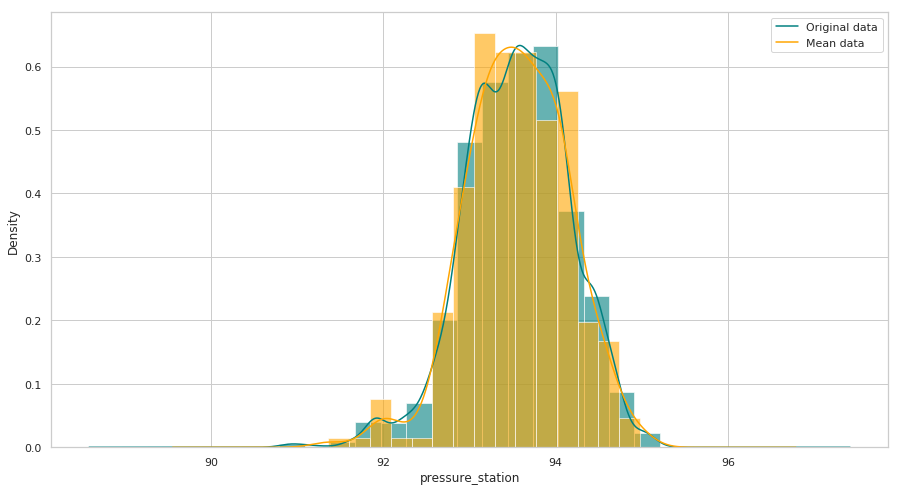

In [330]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [331]:
ks_2samp(weather_data['pressure_station'], pressure_station_mean['pressure_station'])

Ks_2sampResult(statistic=0.02640415140415142, pvalue=0.9924514704997892)

#### mode

In [332]:
pressure_station_mode = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: x.value_counts().index[0]  
})

pressure_station_mode.describe()

,pressure_station
count,273.000000
mean,93.546154
std,0.625402
min,90.920000
25%,93.120000
50%,93.600000
75%,93.980000
max,95.060000


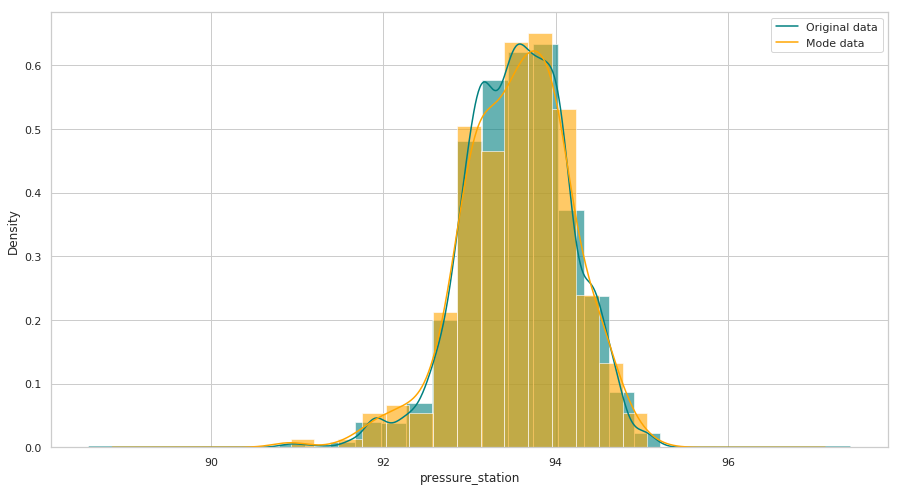

In [333]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [334]:
ks_2samp(weather_data['pressure_station'], pressure_station_mode['pressure_station'])

Ks_2sampResult(statistic=0.026098901098901117, pvalue=0.9934688985072617)

#### median

In [335]:
pressure_station_median = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: x.median() 
})

pressure_station_median.describe()

,pressure_station
count,273.000000
mean,93.568297
std,0.602176
min,91.110000
25%,93.185000
50%,93.565000
75%,93.985000
max,94.985000


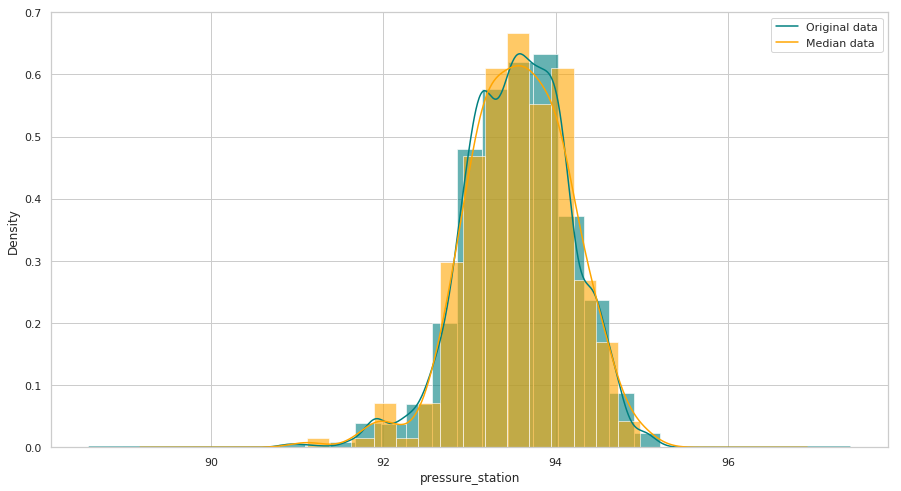

In [336]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [337]:
ks_2samp(weather_data['pressure_station'], pressure_station_median['pressure_station'])

Ks_2sampResult(statistic=0.03434065934065933, pvalue=0.9121099540381511)

It can be seen that for pressure station mode has the highest p-value so it will be chosen for grouping

### Pressure sea

In [338]:
weather_data['pressure_sea'].describe()

count    6551.000000
mean      101.392975
std         0.671077
min        98.400000
25%       100.900000
50%       101.400000
75%       101.900000
max       103.200000
Name: pressure_sea, dtype: float64

#### mean

In [339]:
pressure_sea_mean = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: round(x.mean(), 2)  
})

pressure_sea_mean.describe()

,pressure_sea
count,273.000000
mean,101.392857
std,0.641735
min,99.020000
25%,100.970000
50%,101.370000
75%,101.870000
max,102.980000


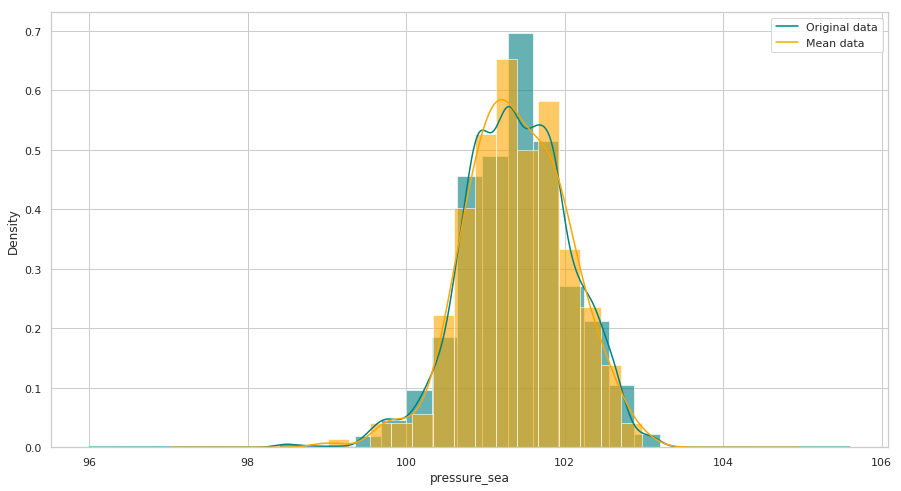

In [340]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [341]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_mean['pressure_sea'])

Ks_2sampResult(statistic=0.04319291819291815, pvalue=0.7033609819040441)

#### mode

In [342]:
pressure_sea_mode = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: x.value_counts().index[0]  
})

pressure_sea_mode.describe()

,pressure_sea
count,273.000000
mean,101.429304
std,0.689271
min,98.500000
25%,100.900000
50%,101.400000
75%,101.900000
max,103.100000


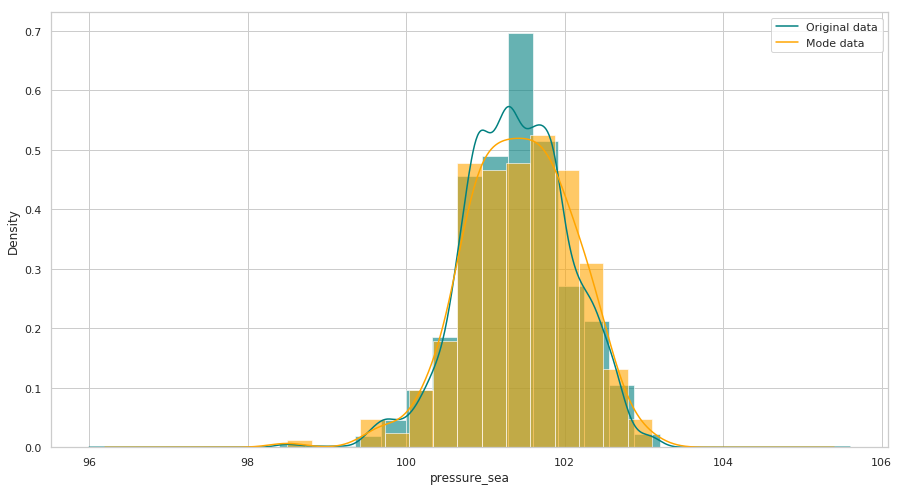

In [343]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [344]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_mode['pressure_sea'])

Ks_2sampResult(statistic=0.04090354090354087, pvalue=0.7646391876680605)

#### median

In [345]:
pressure_sea_median = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: x.median() 
})

pressure_sea_median.describe()

,pressure_sea
count,273.000000
mean,101.410147
std,0.657402
min,98.750000
25%,101.000000
50%,101.400000
75%,101.900000
max,103.000000


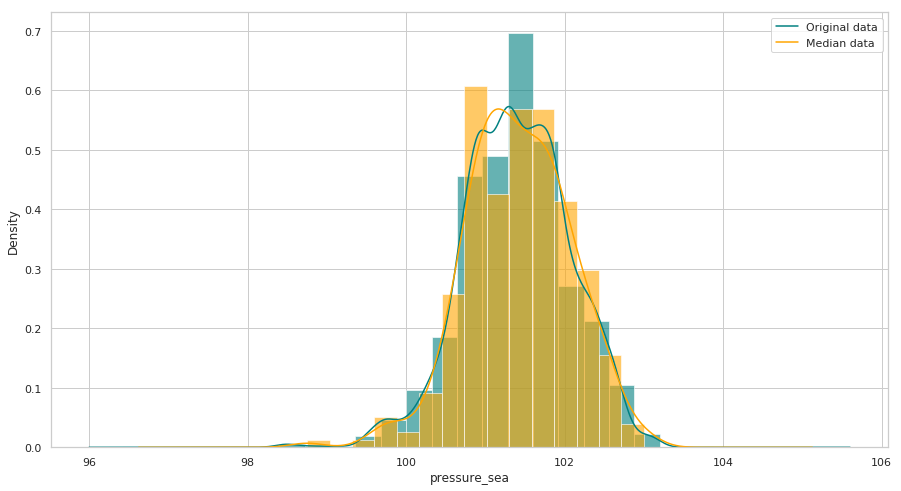

In [346]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [347]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_median['pressure_sea'])

Ks_2sampResult(statistic=0.036324786324786335, pvalue=0.8738453321553711)

It can be seen that for pressure sea median has the highest p-value so it will be chosen for grouping

## Wind_dir_10s
This column represents the wind direction in angles so taking a mean or median doesn't make much sense and mode is expected to be the best method.

In [348]:
weather_data['wind_dir_10s'].describe()

count    6541.000000
mean       21.404220
std         9.914584
min         1.000000
25%        14.000000
50%        23.000000
75%        30.000000
max        36.000000
Name: wind_dir_10s, dtype: float64

#### mean

In [349]:
wind_dir_10s_mean = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: round(x.mean(), 1)  
})

wind_dir_10s_mean.describe()

,wind_dir_10s
count,273.000000
mean,21.407326
std,6.199841
min,5.600000
25%,16.800000
50%,21.900000
75%,26.700000
max,34.400000


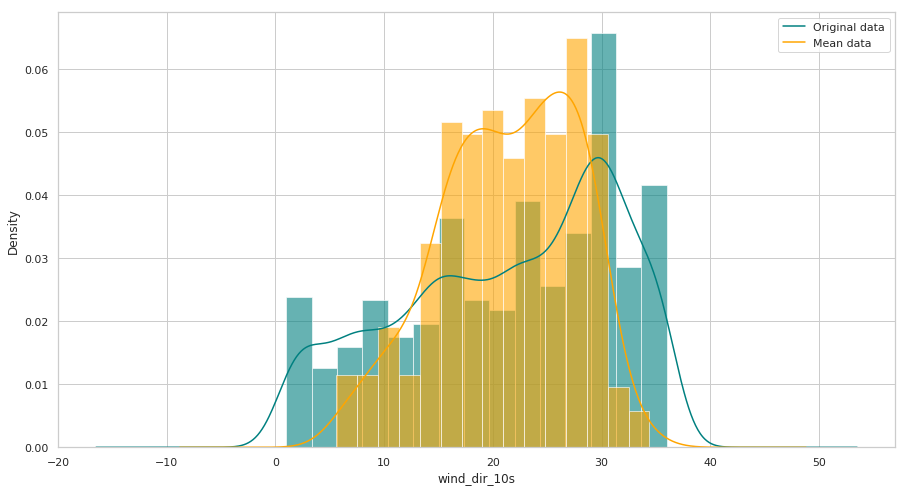

In [350]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [351]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_mean['wind_dir_10s'])

Ks_2sampResult(statistic=0.23061660561660569, pvalue=1.0088860349414771e-12)

#### mode

In [352]:
wind_dir_10s_mode = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: x.value_counts().index[0]   
})

wind_dir_10s_mode.describe()

,wind_dir_10s
count,273.000000
mean,21.805861
std,9.698907
min,1.000000
25%,15.000000
50%,23.000000
75%,30.000000
max,36.000000


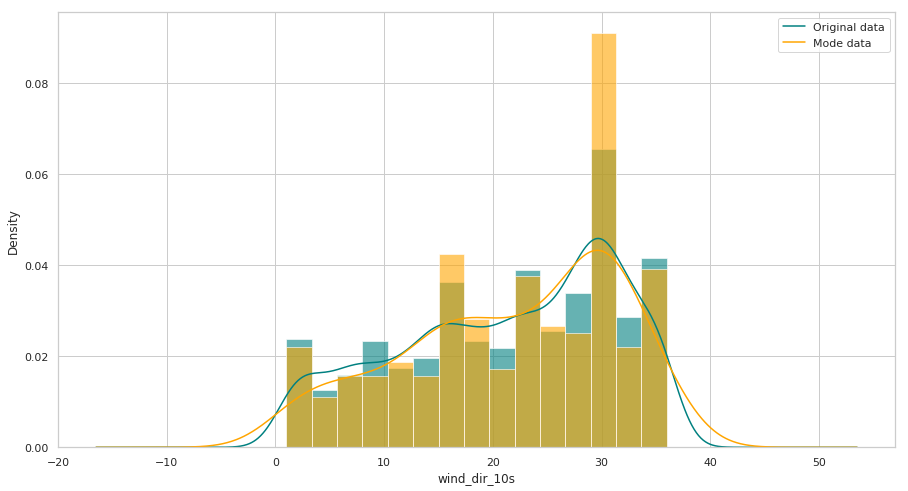

In [353]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [354]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_mode['wind_dir_10s'])

Ks_2sampResult(statistic=0.03724053724053722, pvalue=0.8540558459895058)

#### median

In [355]:
wind_dir_10s_median = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: x.median()  
})

wind_dir_10s_median.describe()

,wind_dir_10s
count,273.000000
mean,21.895604
std,7.838389
min,2.500000
25%,16.500000
50%,22.000000
75%,28.500000
max,35.000000


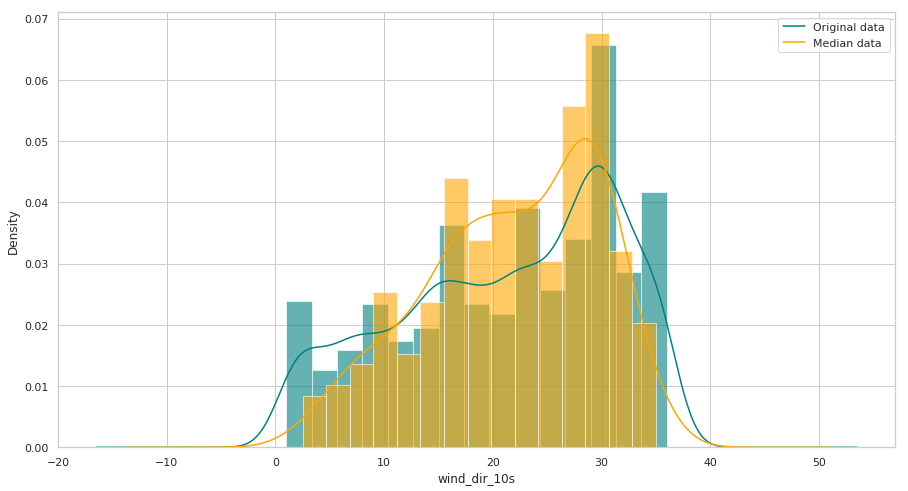

In [356]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [357]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_median['wind_dir_10s'])

Ks_2sampResult(statistic=0.10057997557997556, pvalue=0.009160849960163224)

As expected mode will be the chosen value for wind_dir_10s column as it has the highest p-value, it can be seen that mean doesn't even follow the same distribution and the median barely does follow it.

## Wind_speed

In [358]:
weather_data['wind_speed'].describe()

count    6551.000000
mean       11.838498
std         6.771349
min         0.000000
25%         7.000000
50%        11.000000
75%        16.000000
max        48.000000
Name: wind_speed, dtype: float64

#### mean

In [359]:
wind_speed_mean = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: round(x.mean(),1)  
})

wind_speed_mean.describe()

,wind_speed
count,273.000000
mean,11.839560
std,4.493096
min,3.300000
25%,8.700000
50%,11.400000
75%,14.200000
max,34.800000


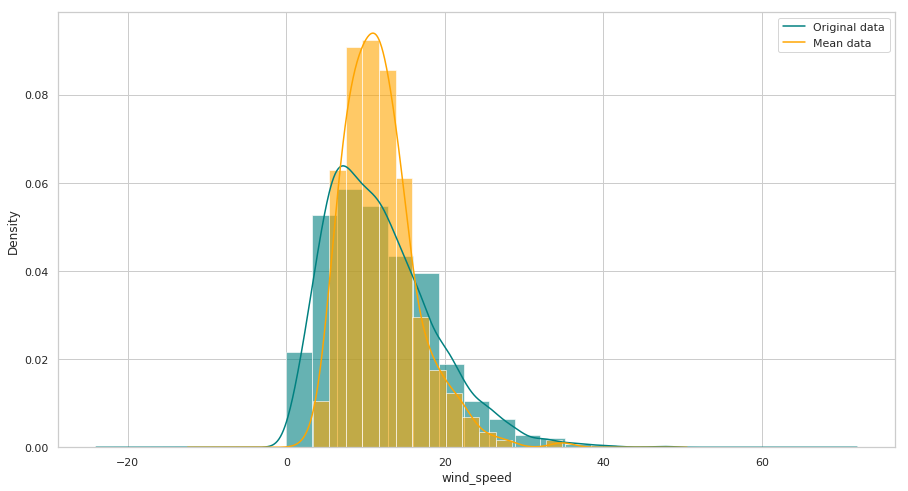

In [360]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [361]:
ks_2samp(weather_data['wind_speed'], wind_speed_mean['wind_speed'])

Ks_2sampResult(statistic=0.18605006105006106, pvalue=1.983581188082017e-08)

#### mode

In [362]:
wind_speed_mode = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: x.value_counts().index[0]  
})

wind_speed_mode.describe()

,wind_speed
count,273.000000
mean,11.146520
std,6.384764
min,1.000000
25%,6.000000
50%,10.000000
75%,14.000000
max,48.000000


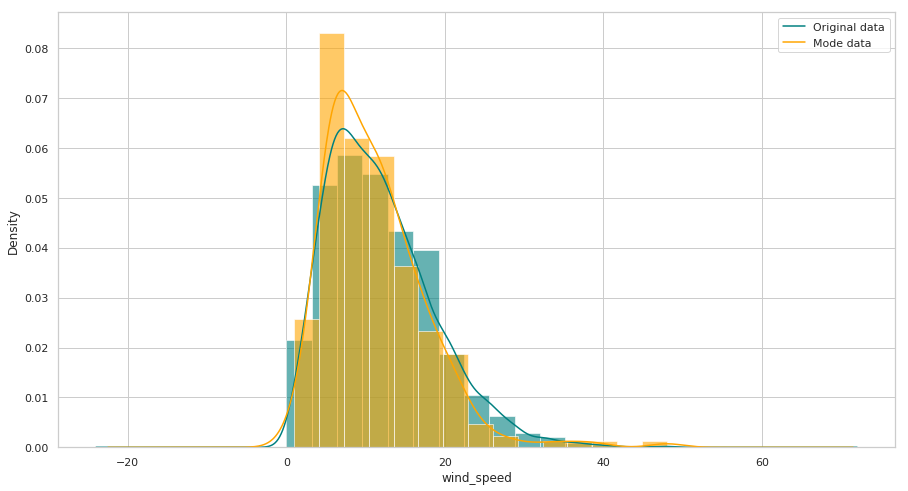

In [363]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [364]:
ks_2samp(weather_data['wind_speed'], wind_speed_mode['wind_speed'])

Ks_2sampResult(statistic=0.06929181929181927, pvalue=0.15511698476590258)

#### median

In [365]:
wind_speed_median = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: x.median()  
})

wind_speed_median.describe()

,wind_speed
count,273.000000
mean,11.597070
std,4.883826
min,3.000000
25%,8.000000
50%,11.000000
75%,14.000000
max,36.500000


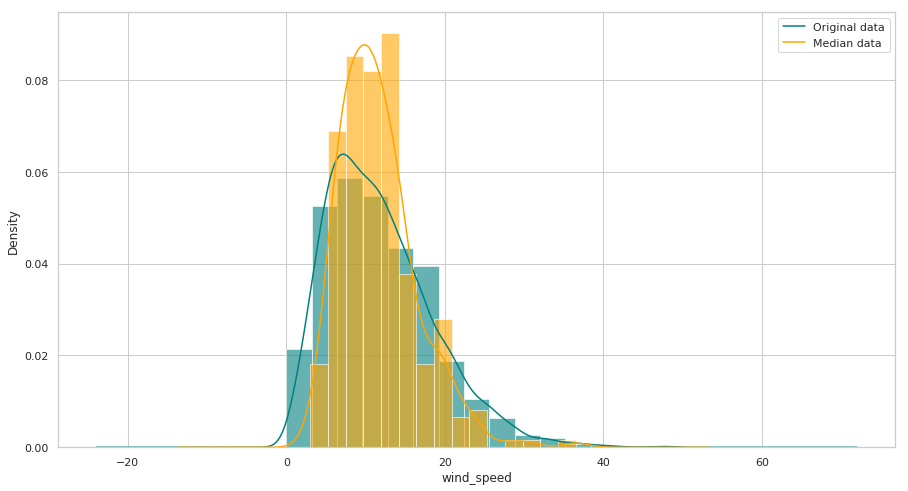

In [366]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [367]:
ks_2samp(weather_data['wind_speed'], wind_speed_median['wind_speed'])

Ks_2sampResult(statistic=0.13843101343101344, pvalue=7.415407851194183e-05)

Mode will be used for wind_speed

## Relative_humidty

In [368]:
weather_data['relative_humidity'].describe()

count    6551.000000
mean       59.654404
std        21.604027
min        14.000000
25%        41.000000
50%        60.000000
75%        79.000000
max        99.000000
Name: relative_humidity, dtype: float64

#### mean

In [369]:
relative_humidity_mean = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: round(x.mean(),1)
})

relative_humidity_mean.describe()

,relative_humidity
count,273.000000
mean,59.654212
std,14.733957
min,27.000000
25%,48.400000
50%,59.200000
75%,69.500000
max,95.600000


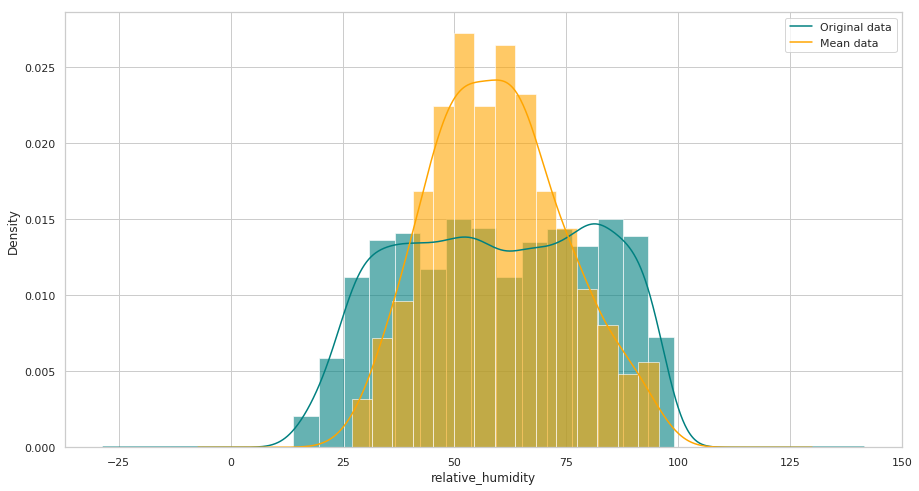

In [370]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [371]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_mean['relative_humidity'])

Ks_2sampResult(statistic=0.16285103785103786, pvalue=1.4756370580775512e-06)

#### mode

In [372]:
relative_humidity_mode = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: x.value_counts().index[0]
})

relative_humidity_mode.describe()

,relative_humidity
count,273.000000
mean,57.545788
std,25.564773
min,15.000000
25%,32.000000
50%,56.000000
75%,82.000000
max,97.000000


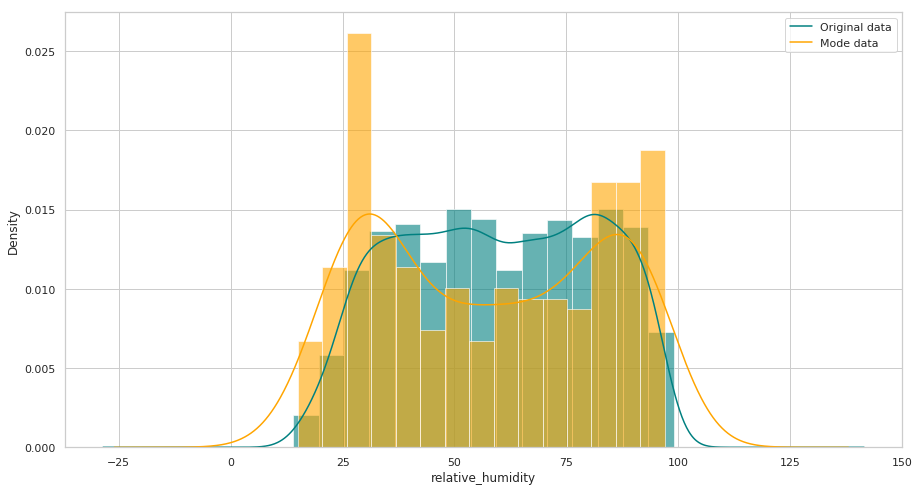

In [373]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [374]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_mode['relative_humidity'])

Ks_2sampResult(statistic=0.1294261294261294, pvalue=0.0002678193400735921)

#### median

In [375]:
relative_humidity_median = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: x.median()
})

relative_humidity_median.describe()

,relative_humidity
count,273.000000
mean,58.586081
std,16.899707
min,20.000000
25%,45.500000
50%,57.500000
75%,69.500000
max,96.000000


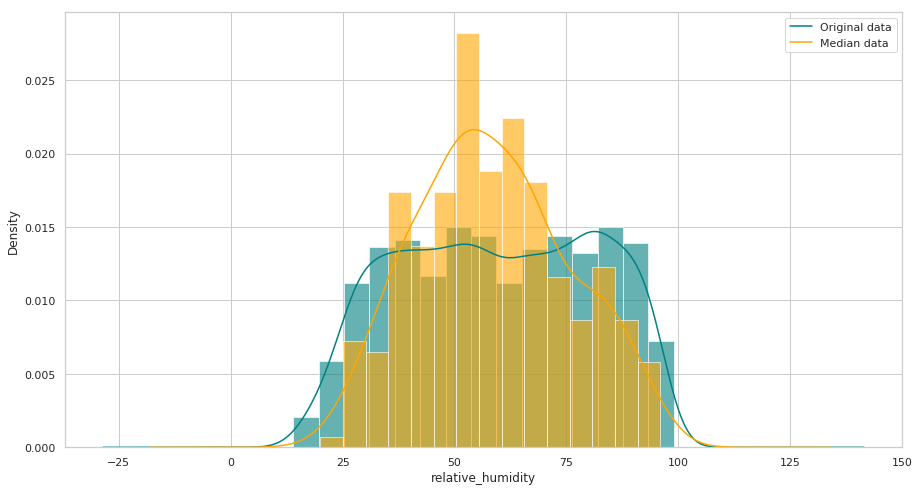

In [376]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [377]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_median['relative_humidity'])

Ks_2sampResult(statistic=0.12484737484737485, pvalue=0.0004977837820255523)

Grouping relative_humidty will introduce bias in the dataset so it will be ignored

## Dew_point

In [378]:
weather_data['dew_point'].describe()

count    6551.000000
mean        7.052068
std         4.213589
min        -9.800000
25%         3.900000
50%         7.300000
75%        10.400000
max        18.500000
Name: dew_point, dtype: float64

#### mean

In [379]:
dew_point_mean = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: round(x.mean(),1)
})

dew_point_mean.describe()

,dew_point
count,273.000000
mean,7.049817
std,3.825304
min,-4.800000
25%,4.200000
50%,7.200000
75%,10.200000
max,15.200000


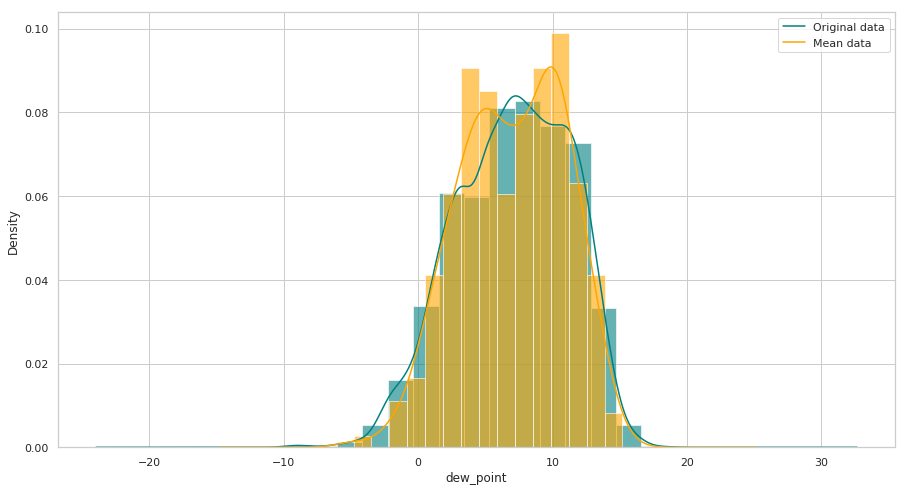

In [380]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [381]:
ks_2samp(weather_data['dew_point'], dew_point_mean['dew_point'])

Ks_2sampResult(statistic=0.0506715506715506, pvalue=0.5013102678262382)

#### mode

In [382]:
dew_point_mode = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: x.value_counts().index[0]
})

dew_point_mode.describe()

,dew_point
count,273.000000
mean,7.215751
std,4.120261
min,-4.200000
25%,3.800000
50%,7.200000
75%,10.700000
max,16.000000


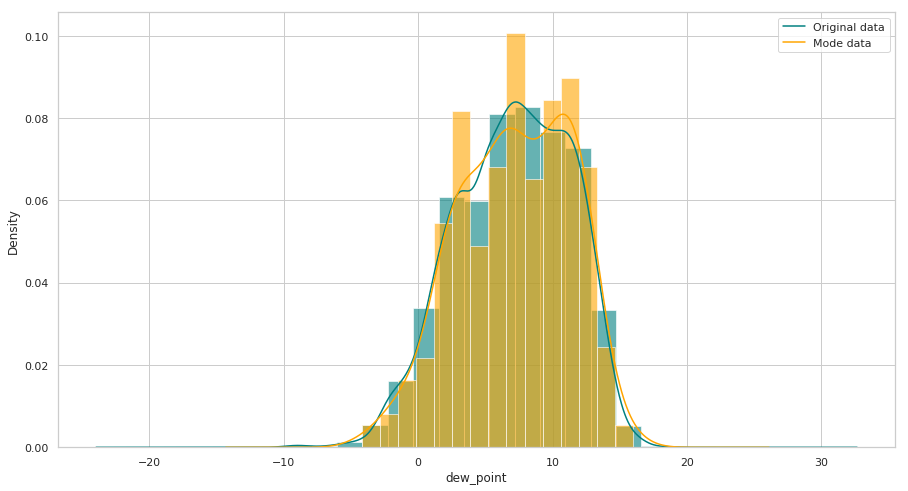

In [383]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [384]:
ks_2samp(weather_data['dew_point'], dew_point_mode['dew_point'])

Ks_2sampResult(statistic=0.03495115995115994, pvalue=0.9010558836474287)

#### median

In [385]:
dew_point_median = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: x.median()
})

dew_point_median.describe()

,dew_point
count,273.000000
mean,7.092491
std,3.907128
min,-4.200000
25%,4.200000
50%,7.300000
75%,10.250000
max,15.100000


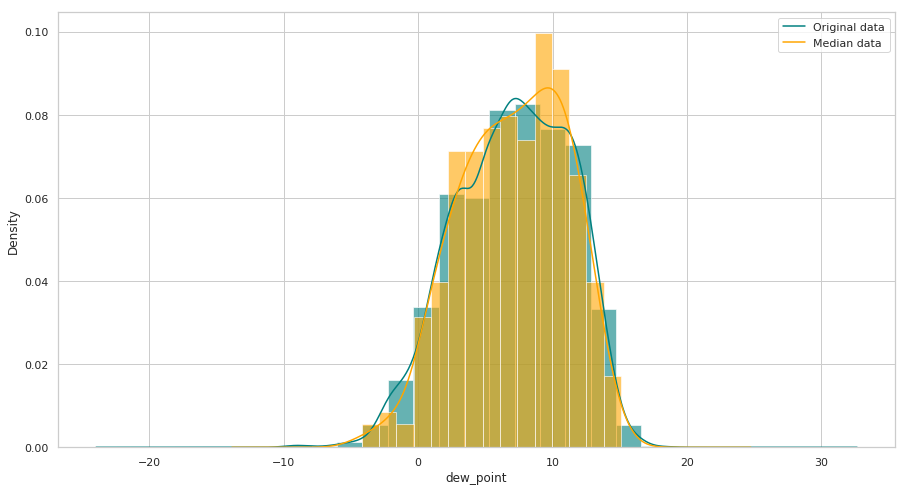

In [386]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [387]:
ks_2samp(weather_data['dew_point'], dew_point_median['dew_point'])

Ks_2sampResult(statistic=0.04319291819291815, pvalue=0.7033609819040441)

Mode will be used for dew_point

## Temperature

In [388]:
weather_data['temperature'].describe()

count    6551.000000
mean       16.101359
std         6.170529
min        -1.700000
25%        12.000000
50%        16.000000
75%        20.500000
max        34.300000
Name: temperature, dtype: float64

#### mean

In [389]:
temperature_mean = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: round(x.mean(),1)
})

temperature_mean.describe()

,temperature
count,273.000000
mean,16.102930
std,4.734137
min,-0.600000
25%,14.000000
50%,16.500000
75%,19.600000
max,25.400000


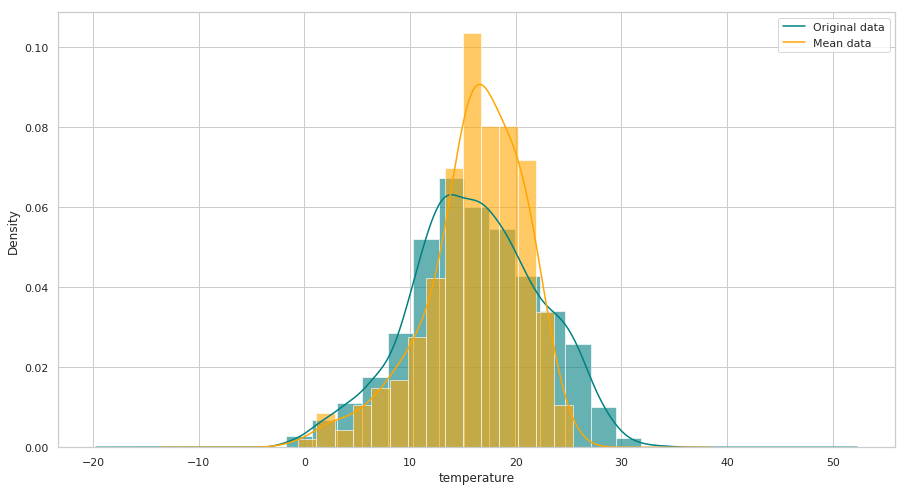

In [390]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [391]:
ks_2samp(weather_data['temperature'], temperature_mean['temperature'])

Ks_2sampResult(statistic=0.12744200244200243, pvalue=0.0003513056115421442)

#### mode

In [392]:
temperature_mode = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: x.value_counts().index[0]
})

temperature_mode.describe()

,temperature
count,273.000000
mean,15.867399
std,6.594845
min,-1.500000
25%,11.600000
50%,15.500000
75%,20.600000
max,31.800000


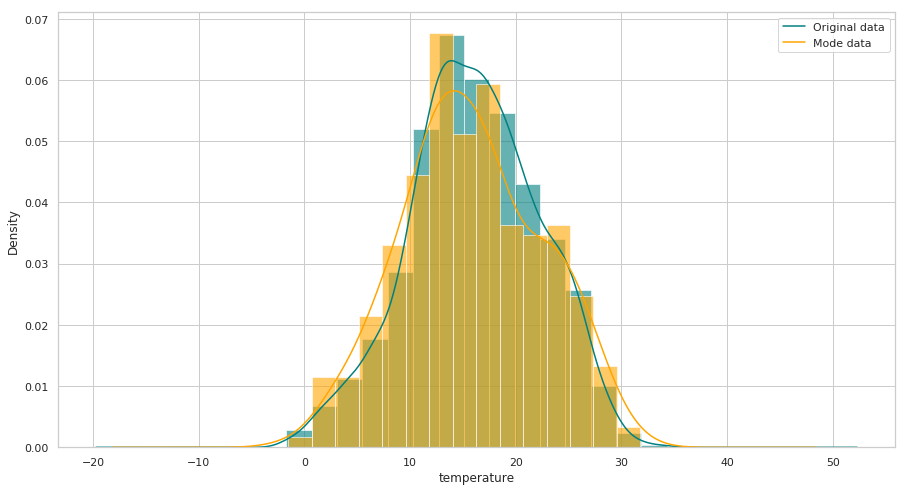

In [393]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [394]:
ks_2samp(weather_data['temperature'], temperature_mode['temperature'])

Ks_2sampResult(statistic=0.0463980463980464, pvalue=0.6153694189017159)

#### median

In [395]:
temperature_median = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: x.median()
})

temperature_median.describe()

,temperature
count,273.000000
mean,16.196337
std,4.939260
min,-0.550000
25%,13.850000
50%,16.850000
75%,19.700000
max,26.250000


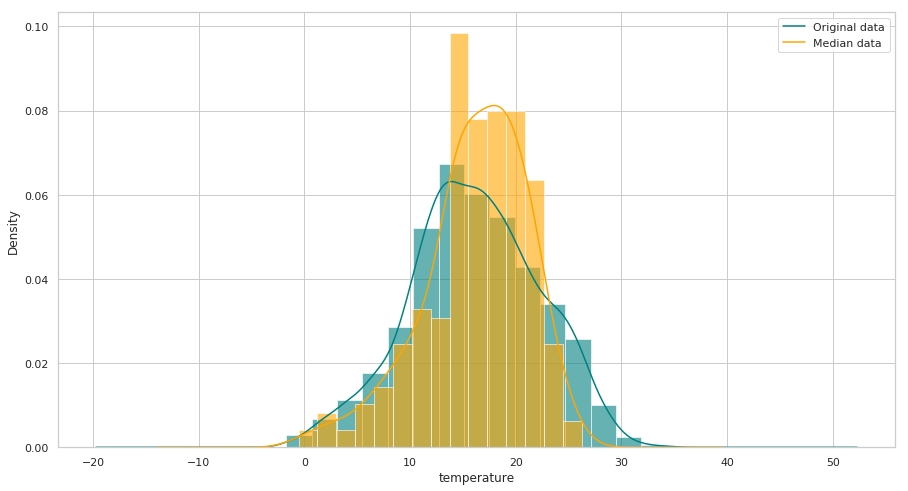

In [396]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [397]:
ks_2samp(weather_data['temperature'], temperature_median['temperature'])

Ks_2sampResult(statistic=0.12805250305250304, pvalue=0.0003233103118640017)

Mode will be used for temperature

## Health_index

In [398]:
weather_data['health_index'].describe()

count    6502.000000
mean        2.617733
std         1.237344
min         1.000000
25%         1.900000
50%         2.400000
75%         3.000000
max        11.000000
Name: health_index, dtype: float64

#### mean

In [399]:
health_index_mean = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: round(x.mean(),1)
})

health_index_mean.describe()

,health_index
count,273.000000
mean,2.615018
std,1.022483
min,1.000000
25%,2.000000
50%,2.500000
75%,2.900000
max,7.900000


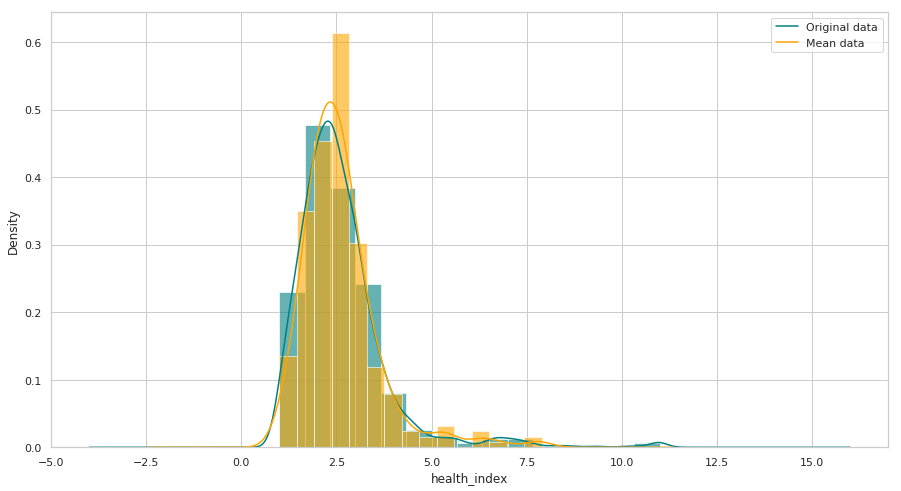

In [400]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [401]:
ks_2samp(weather_data['health_index'], health_index_mean['health_index'])

Ks_2sampResult(statistic=0.0608974358974359, pvalue=0.2769419390872273)

#### mode

In [402]:
health_index_mode = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: x.value_counts().index[0]
})

health_index_mode.describe()

,health_index
count,273.000000
mean,2.539927
std,1.284086
min,1.000000
25%,1.900000
50%,2.300000
75%,2.900000
max,11.000000


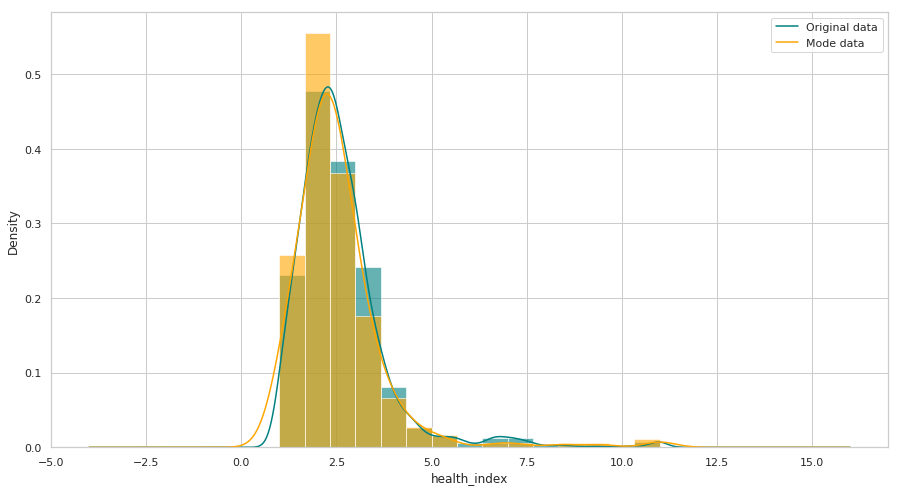

In [403]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [404]:
ks_2samp(weather_data['health_index'], health_index_mode['health_index'])

Ks_2sampResult(statistic=0.07356532356532353, pvalue=0.11210527756808653)

#### median

In [405]:
health_index_median = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: x.median()
})

health_index_median.describe()

,health_index
count,273.000000
mean,2.534432
std,0.975153
min,1.000000
25%,1.950000
50%,2.400000
75%,2.900000
max,7.650000


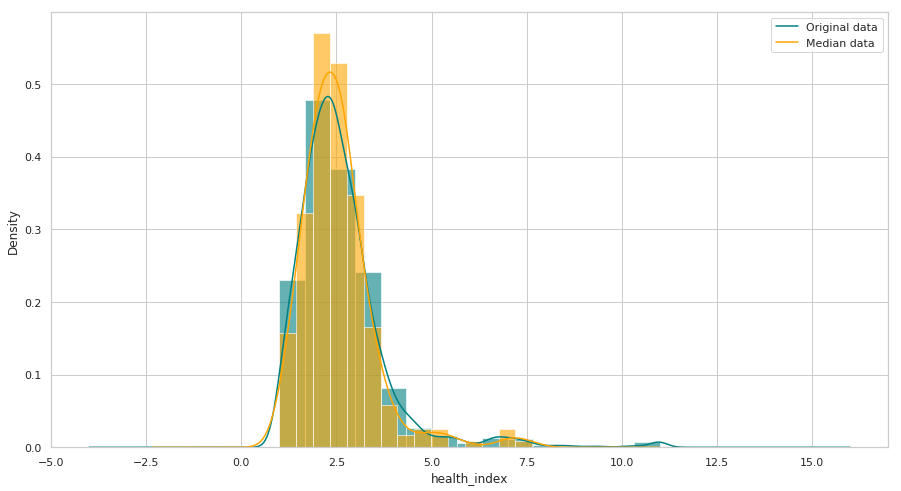

In [406]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [407]:
ks_2samp(weather_data['health_index'], health_index_median['health_index'])

Ks_2sampResult(statistic=0.06547619047619047, pvalue=0.20384478235583928)

Mean will be used for health_index

## Grouping weather data by date
- Pressure station by mode
- Pressure sea by median
- wind_dir_10s by mode
- wind_speed by mode
- relative_humidty ignored
- dew_point by mode
- temperature by mode
- health_index by mean

In [408]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

weather_data_grouped.head()

273


,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-10,93.47,101.30,7.0,6.0,3.4,11.9,3.5
1,2017-05-11,93.61,101.40,11.0,6.0,5.9,7.2,3.2
2,2017-05-12,93.04,100.65,11.0,27.0,2.4,12.2,2.8
3,2017-05-13,92.37,100.40,9.0,9.0,5.3,6.3,1.8
4,2017-05-14,92.94,100.80,31.0,12.0,2.7,8.5,1.6


In [409]:
weather_data_grouped.isnull().sum()

date_time_local     0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

#### Further group weather data by week

In [410]:
weather_data_grouped.sort_values('date_time_local', inplace=True)
weather_data_grouped.head(7)

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-10,93.47,101.30,7.0,6.0,3.4,11.9,3.5
1,2017-05-11,93.61,101.40,11.0,6.0,5.9,7.2,3.2
2,2017-05-12,93.04,100.65,11.0,27.0,2.4,12.2,2.8
3,2017-05-13,92.37,100.40,9.0,9.0,5.3,6.3,1.8
4,2017-05-14,92.94,100.80,31.0,12.0,2.7,8.5,1.6
5,2017-05-15,92.94,100.90,23.0,8.0,4.4,5.5,2.0
6,2017-05-16,92.96,100.95,6.0,12.0,3.5,2.4,2.0


In [411]:
weather_data_grouped = weather_data_grouped.groupby(weather_data_grouped.index // 7).agg({
    'date_time_local': 'last',
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

39


## Grouping mosquito data


There are 3 candidate columns to group mosquito data by:
- Trap_date: date of trapping mosquitos
- Genus: When biologists talk about a genus, they mean one or more species of animals or plants that are closely related to each other. Low-level taxonomic ranking for biological classification.
- Specific Epithet: lowest taxonomic rank and having common characteristics and (usually) capable of mating with one another.

Add Gender for part B

In [412]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,Count,Trap Region,Comparison Group,Latitude,Longitude,Location
19195,2017-05-16,Ochlerotatus,Black legs,Female,13,Residential GC-South,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
6338,2017-05-16,Ochlerotatus,Black legs,Female,1,Outer Community-South1,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)
888,2017-05-16,Culiseta,alaskaensis,Female,1,Residential GC-South,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
26275,2017-05-16,Male,UnID,Male,1,River Valley-East-P1,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)
18595,2017-05-16,Culiseta,inornata,Female,1,Rural-North West,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)


In [413]:
mos_data_grouped = mos_data.groupby(['Trap Date'], as_index=False).agg({
    'Count' : 'sum',
    'Genus': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0]
})

print(len(mos_data_grouped.index))

mos_data_grouped.head()

39


,Trap Date,Count,Genus,Gender
0,2017-05-16,29,Culiseta,Female
1,2017-05-23,523,Ochlerotatus,Female
2,2017-05-30,363,Ochlerotatus,Female
3,2017-06-06,1656,Ochlerotatus,Female
4,2017-06-13,2969,Ochlerotatus,Female


In [414]:
merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

print(len(merged_data.index))

merged_data.drop(columns=['date_time_local'], inplace=True) #redundent

merged_data.head()

39


,Trap Date,Count,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-16,29,Culiseta,Female,92.94,100.90,11.0,12.0,5.3,2.4,2.4
1,2017-05-23,523,Ochlerotatus,Female,92.37,101.90,20.0,6.0,5.1,22.9,2.5
2,2017-05-30,363,Ochlerotatus,Female,94.06,101.30,15.0,21.0,5.3,11.0,2.5
3,2017-06-06,1656,Ochlerotatus,Female,93.81,101.05,31.0,12.0,7.7,11.8,2.8
4,2017-06-13,2969,Ochlerotatus,Female,91.87,100.85,34.0,16.0,6.6,10.4,2.5


In [415]:
merged_data.isnull().sum()

Trap Date           0
Count               0
Genus               0
Gender              0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

## Add features
- isWarm: if temperature is above 20 = 1, else = 0.
- add genusCat for Genus
- add genderCat female = 1, male = 0
- add delta_pressure = pressure_station - pressure_sea

In [416]:
merged_data['isWarm'] = np.where(merged_data['temperature'] >= 20, 1, 0)

In [417]:
merged_data['Genus'] = merged_data['Genus'].astype('category')
merged_data['genusCat'] = merged_data['Genus'].cat.codes

In [418]:
# merged_data['genderCat'] = np.where(merged_data['Gender'] == "Female", 1, 0)

In [419]:
merged_data["delta_pressure"] = merged_data.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

In [420]:
merged_data.head()

,Trap Date,Count,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index,isWarm,genusCat,delta_pressure
0,2017-05-16,29,Culiseta,Female,92.94,100.90,11.0,12.0,5.3,2.4,2.4,0,1,-7.96
1,2017-05-23,523,Ochlerotatus,Female,92.37,101.90,20.0,6.0,5.1,22.9,2.5,1,3,-9.53
2,2017-05-30,363,Ochlerotatus,Female,94.06,101.30,15.0,21.0,5.3,11.0,2.5,0,3,-7.24
3,2017-06-06,1656,Ochlerotatus,Female,93.81,101.05,31.0,12.0,7.7,11.8,2.8,0,3,-7.24
4,2017-06-13,2969,Ochlerotatus,Female,91.87,100.85,34.0,16.0,6.6,10.4,2.5,0,3,-8.98


# Part A: Linear Regression for no_of_Mosquito = function(weather_features)

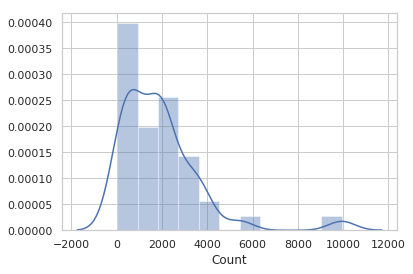

In [421]:
sns.distplot(merged_data['Count'])

In [422]:
merged_data['Count'].describe()

count      39.000000
mean     1905.923077
std      1833.551434
min        29.000000
25%       674.500000
50%      1779.000000
75%      2231.000000
max      9938.000000
Name: Count, dtype: float64

In [423]:
#merged_data = merged_data[merged_data['Count'] < merged_data['Count'].describe()['75%']]  

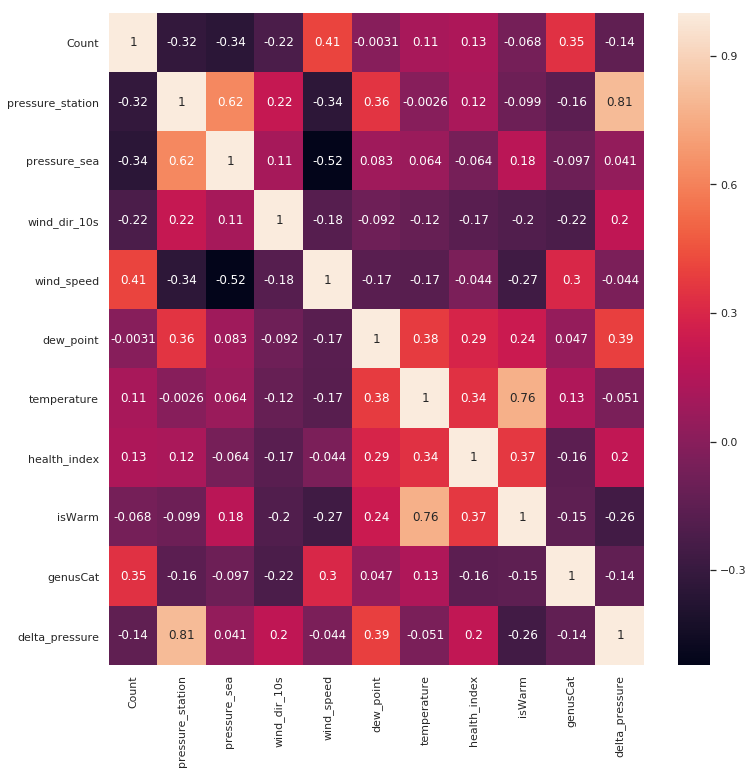

In [424]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data.corr(), annot=True, ax=ax)

In [425]:
x_cols = ['wind_dir_10s', 'wind_speed', 'genusCat', 'delta_pressure']
X = merged_data[x_cols]
y = merged_data['Count']

In [426]:
from sklearn.preprocessing import StandardScaler

x_cols = ['wind_dir_10s', 'wind_speed', 'delta_pressure']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [427]:
from sklearn.model_selection import train_test_split

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)


In [428]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [429]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_train_norm,y_train_norm)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_train_stand,y_train_stand)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_train_both,y_train_both)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [430]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

-2219.4273966653927


,Coefficient
wind_dir_10s,-8.776239
wind_speed,117.027118
genusCat,492.149052
delta_pressure,-239.702268


In [431]:
print(lin_reg_norm.intercept_)
coeff_df = pd.DataFrame(lin_reg_norm.coef_, X.columns, columns=['Coefficient'])
coeff_df

524.2674555497897


,Coefficient
wind_dir_10s,-307.168367
wind_speed,3744.867782
genusCat,492.149052
delta_pressure,-680.754442


In [432]:
print(lin_reg_stand.intercept_)
coeff_df = pd.DataFrame(lin_reg_stand.coef_, X.columns, columns=['Coefficient'])
coeff_df

734.705650365556


,Coefficient
wind_dir_10s,-72.773340
wind_speed,683.381600
genusCat,492.149052
delta_pressure,-123.544190


In [433]:
print(lin_reg_both.intercept_)
coeff_df = pd.DataFrame(lin_reg_both.coef_, X.columns, columns=['Coefficient'])
coeff_df

734.705650365556


,Coefficient
wind_dir_10s,-72.773340
wind_speed,683.381600
genusCat,492.149052
delta_pressure,-123.544190


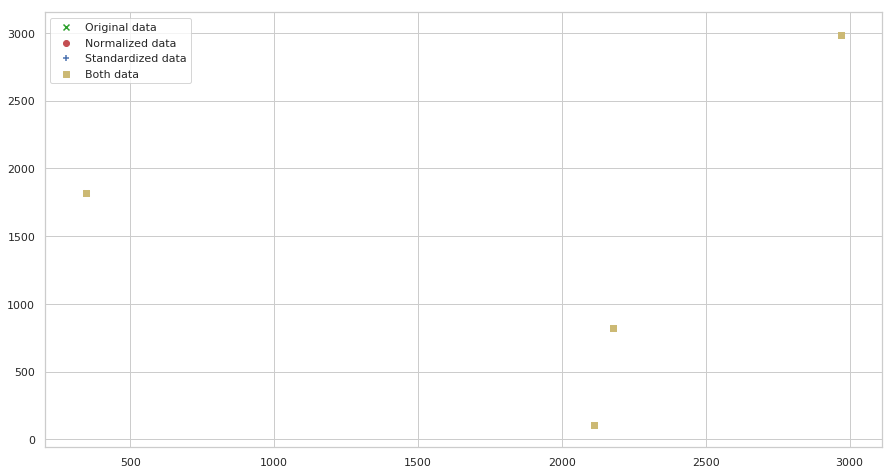

In [434]:
pred = lin_reg.predict(X_test)
pred_norm = lin_reg_norm.predict(X_test_norm)
pred_stand = lin_reg_stand.predict(X_test_stand)
pred_both = lin_reg_both.predict(X_test_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y_test, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y_test_norm, pred, c='r', marker='o', label='Normalized data')
ax.scatter(y_test_stand, pred, c='b', marker='+', label='Standardized data')
ax.scatter(y_test_both, pred, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

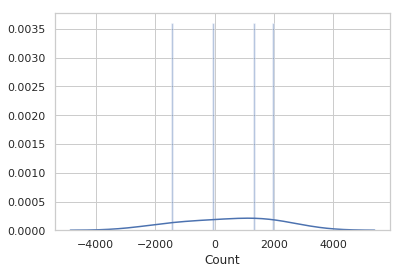

In [435]:
sns.distplot((y_test - pred), bins=50);

In [436]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1211.5551060786324
MSE: 2004786.0720211174
RMSE: 1415.9046832400538
R2 Square -1.177006468553178
Train set evaluation:
_____________________________________
MAE: 1190.5486840408291
MSE: 2584433.1541309524
RMSE: 1607.6172287366644
R2 Square 0.27092830321649


In [437]:
test_pred_norm = lin_reg_norm.predict(X_test_norm)
train_pred_norm = lin_reg_norm.predict(X_train_norm)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_norm, test_pred_norm)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_norm, train_pred_norm)

Test set evaluation:
_____________________________________
MAE: 1211.5551060786352
MSE: 2004786.0720211235
RMSE: 1415.904683240056
R2 Square -1.1770064685531847
Train set evaluation:
_____________________________________
MAE: 1190.5486840408296
MSE: 2584433.154130953
RMSE: 1607.6172287366644
R2 Square 0.27092830321648986


In [438]:
test_pred_stand = lin_reg_stand.predict(X_test_stand)
train_pred_stand = lin_reg_stand.predict(X_train_stand)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_stand, test_pred_stand)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_stand, train_pred_stand)

Test set evaluation:
_____________________________________
MAE: 1211.555106078634
MSE: 2004786.0720211212
RMSE: 1415.9046832400552
R2 Square -1.177006468553182
Train set evaluation:
_____________________________________
MAE: 1190.5486840408296
MSE: 2584433.1541309524
RMSE: 1607.6172287366644
R2 Square 0.27092830321649


In [439]:
test_pred_both = lin_reg_both.predict(X_test_both)
train_pred_both = lin_reg_both.predict(X_train_both)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_both, test_pred_both)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_both, train_pred_both)

Test set evaluation:
_____________________________________
MAE: 1211.5551060786333
MSE: 2004786.0720211195
RMSE: 1415.9046832400547
R2 Square -1.1770064685531803
Train set evaluation:
_____________________________________
MAE: 1190.5486840408296
MSE: 2584433.154130952
RMSE: 1607.6172287366642
R2 Square 0.2709283032164902


In [440]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())], ["Linear Regression w/ norm", *evaluate(y_test_norm, test_pred_norm) , cross_val(LinearRegression())], ["Linear Regression w/ stand", *evaluate(y_test_stand, test_pred_stand) , cross_val(LinearRegression())],["Linear Regression w/ both", *evaluate(y_test_both, test_pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,1211.555106,2.004786e+06,1415.904683,-1.177006,-8.925981
1,Linear Regression w/ norm,1211.555106,2.004786e+06,1415.904683,-1.177006,-8.925981
2,Linear Regression w/ stand,1211.555106,2.004786e+06,1415.904683,-1.177006,-8.925981
3,Linear Regression w/ both,1211.555106,2.004786e+06,1415.904683,-1.177006,-8.925981


# Part B: count depending on Gender

In [441]:
mos_data_grouped_B = mos_data.groupby(['Trap Date', 'Gender'], as_index=False).agg({
    'Count' : 'sum',
    'Genus': lambda x: x.value_counts().index[0],
})

print(len(mos_data_grouped_B.index))

mos_data_grouped_B.head()

78


,Trap Date,Gender,Count,Genus
0,2017-05-16,Female,23,Culiseta
1,2017-05-16,Male,6,Male
2,2017-05-23,Female,198,Ochlerotatus
3,2017-05-23,Male,325,Male
4,2017-05-30,Female,150,Ochlerotatus


In [442]:
mos_data_grouped_B_females = mos_data_grouped_B[mos_data_grouped_B["Gender"] == "Female"]
mos_data_grouped_B_males = mos_data_grouped_B[mos_data_grouped_B["Gender"] == "Male"]

In [443]:
print(len(mos_data_grouped_B_females.index), len(mos_data_grouped_B_males.index))

39 39


## Linear Regression

### Females

In [444]:
merged_data_females = pd.merge(left=mos_data_grouped_B_females, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

print(len(merged_data_females.index))

merged_data_females.drop(columns=['date_time_local'], inplace=True) #redundent

merged_data_females.head()

39


,Trap Date,Gender,Count,Genus,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-16,Female,23,Culiseta,92.94,100.90,11.0,12.0,5.3,2.4,2.4
1,2017-05-23,Female,198,Ochlerotatus,92.37,101.90,20.0,6.0,5.1,22.9,2.5
2,2017-05-30,Female,150,Ochlerotatus,94.06,101.30,15.0,21.0,5.3,11.0,2.5
3,2017-06-06,Female,526,Ochlerotatus,93.81,101.05,31.0,12.0,7.7,11.8,2.8
4,2017-06-13,Female,1261,Ochlerotatus,91.87,100.85,34.0,16.0,6.6,10.4,2.5


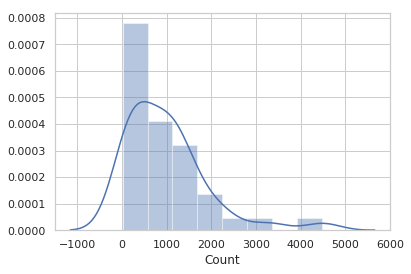

In [445]:
sns.distplot(merged_data_females['Count'])

In [446]:
merged_data_females['isWarm'] = np.where(merged_data_females['temperature'] >= 20, 1, 0)

In [447]:
merged_data_females['Genus'] = merged_data_females['Genus'].astype('category')
merged_data_females['genusCat'] = merged_data_females['Genus'].cat.codes

In [448]:
merged_data_females["delta_pressure"] = merged_data_females.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

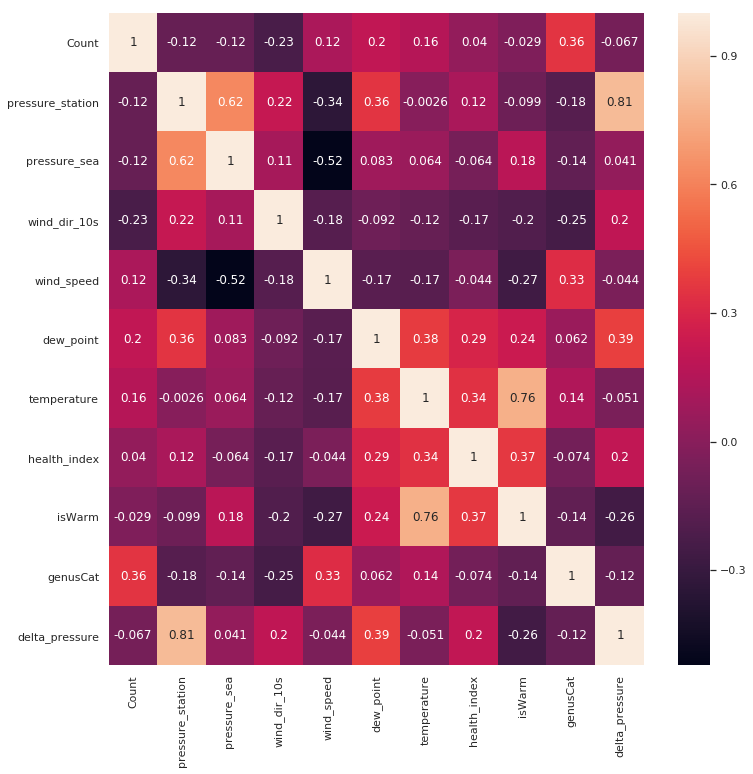

In [449]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data_females.corr(), annot=True, ax=ax)

In [450]:
x_cols = ['pressure_station', 'wind_speed', 'dew_point', 'temperature', 'genusCat', 'delta_pressure']
X = merged_data_females[x_cols]
y = merged_data_females['Count']

In [451]:
from sklearn.preprocessing import StandardScaler

x_cols = ['pressure_station', 'wind_speed', 'dew_point', 'temperature', 'delta_pressure']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [452]:
from sklearn.model_selection import train_test_split

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)


In [453]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [454]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_train_norm,y_train_norm)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_train_stand,y_train_stand)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_train_both,y_train_both)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [455]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

17640.965649100115


,Coefficient
pressure_station,-189.640279
wind_speed,6.440568
dew_point,50.166612
temperature,-4.012016
genusCat,608.895259
delta_pressure,33.528593


In [456]:
print(lin_reg_norm.intercept_)
coeff_df = pd.DataFrame(lin_reg_norm.coef_, X.columns, columns=['Coefficient'])
coeff_df

-14.44755257245663


,Coefficient
pressure_station,-604.952489
wind_speed,206.098163
dew_point,627.082646
temperature,-101.905195
genusCat,608.895259
delta_pressure,95.221205


In [457]:
print(lin_reg_stand.intercept_)
coeff_df = pd.DataFrame(lin_reg_stand.coef_, X.columns, columns=['Coefficient'])
coeff_df

13.434243026095373


,Coefficient
pressure_station,-124.493182
wind_speed,37.609790
dew_point,185.800228
temperature,-25.667328
genusCat,608.895259
delta_pressure,17.280866


In [458]:
print(lin_reg_both.intercept_)
coeff_df = pd.DataFrame(lin_reg_both.coef_, X.columns, columns=['Coefficient'])
coeff_df

13.43424302609219


,Coefficient
pressure_station,-124.493182
wind_speed,37.609790
dew_point,185.800228
temperature,-25.667328
genusCat,608.895259
delta_pressure,17.280866


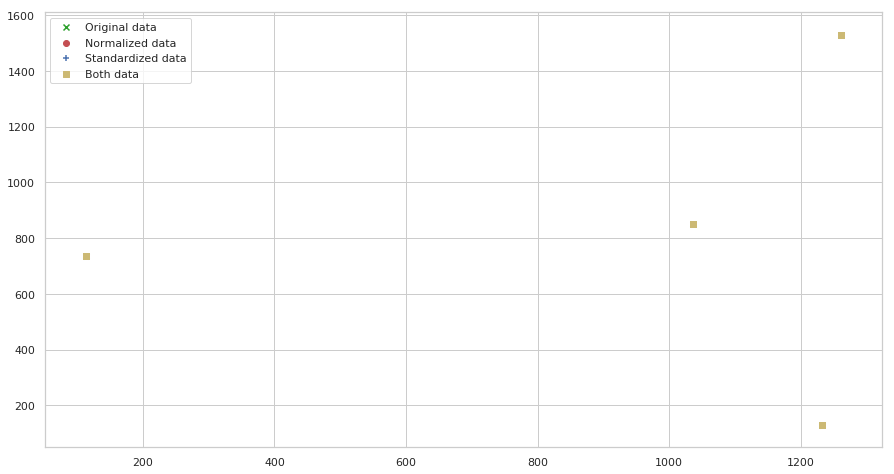

In [459]:
pred = lin_reg.predict(X_test)
pred_norm = lin_reg_norm.predict(X_test_norm)
pred_stand = lin_reg_stand.predict(X_test_stand)
pred_both = lin_reg_both.predict(X_test_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y_test, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y_test_norm, pred, c='r', marker='o', label='Normalized data')
ax.scatter(y_test_stand, pred, c='b', marker='+', label='Standardized data')
ax.scatter(y_test_both, pred, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

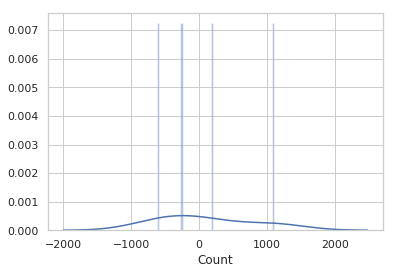

In [460]:
sns.distplot((y_test - pred), bins=50);

In [461]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 544.5397062309944
MSE: 427395.75188412576
RMSE: 653.7551161437483
R2 Square -0.9457753231289929
Train set evaluation:
_____________________________________
MAE: 588.0423759612548
MSE: 738925.9046214353
RMSE: 859.6079947402975
R2 Square 0.1946880675131386


In [462]:
test_pred_norm = lin_reg_norm.predict(X_test_norm)
train_pred_norm = lin_reg_norm.predict(X_train_norm)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_norm, test_pred_norm)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_norm, train_pred_norm)

Test set evaluation:
_____________________________________
MAE: 544.5397062309944
MSE: 427395.7518841264
RMSE: 653.7551161437488
R2 Square -0.9457753231289958
Train set evaluation:
_____________________________________
MAE: 588.0423759612559
MSE: 738925.904621436
RMSE: 859.607994740298
R2 Square 0.19468806751313794


In [463]:
test_pred_stand = lin_reg_stand.predict(X_test_stand)
train_pred_stand = lin_reg_stand.predict(X_train_stand)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_stand, test_pred_stand)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_stand, train_pred_stand)

Test set evaluation:
_____________________________________
MAE: 544.5397062309951
MSE: 427395.7518841272
RMSE: 653.7551161437493
R2 Square -0.9457753231289996
Train set evaluation:
_____________________________________
MAE: 588.0423759612559
MSE: 738925.904621436
RMSE: 859.607994740298
R2 Square 0.19468806751313794


In [464]:
test_pred_both = lin_reg_both.predict(X_test_both)
train_pred_both = lin_reg_both.predict(X_train_both)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_both, test_pred_both)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_both, train_pred_both)

Test set evaluation:
_____________________________________
MAE: 544.5397062309949
MSE: 427395.7518841268
RMSE: 653.7551161437491
R2 Square -0.9457753231289976
Train set evaluation:
_____________________________________
MAE: 588.0423759612559
MSE: 738925.9046214363
RMSE: 859.6079947402981
R2 Square 0.19468806751313772


In [465]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())], ["Linear Regression w/ norm", *evaluate(y_test_norm, test_pred_norm) , cross_val(LinearRegression())], ["Linear Regression w/ stand", *evaluate(y_test_stand, test_pred_stand) , cross_val(LinearRegression())],["Linear Regression w/ both", *evaluate(y_test_both, test_pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,544.539706,427395.751884,653.755116,-0.945775,-16.890209
1,Linear Regression w/ norm,544.539706,427395.751884,653.755116,-0.945775,-16.890209
2,Linear Regression w/ stand,544.539706,427395.751884,653.755116,-0.945775,-16.890209
3,Linear Regression w/ both,544.539706,427395.751884,653.755116,-0.945775,-16.890209
